# Lineær Regresjon (løsningsforslag til oppgave fra 22. januar)

La oss fortsette med det klassiske datasettet som inneholder data om størrlsen (lende og bredde) av begerbladene (engelsk: sepal) (de ytre bladene i en blomst) og kronbladene (engelsk: petal) til tre ulike type Iris (setosa, versicolor og virginica) - på norsk hhv.: vill iris, praktiris og blått flagg iris). Vi skal bruke dette datasettet til å se nærmere på lineær regresjon. Først må vi importere noen pakker og lese inn datasettet.

In [1]:
from sklearn.datasets import load_iris

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.stats import expon
import math

Datasettet er tilgjengelig direkte fra ScikitLearn

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

Nå er typen iris lagret som 0, 1 og 2. Vi vil gjerne oversette dette til faktiske navn slik at vi ikke glemmer hva de ulike tallene betyr. Dette kan vi gjøre på flere måter, men en mulighet er å bruke såkalte lambda-funksjoner som utfører en test av hvert enkelt element in en kolonne. 

In [4]:
df['species'] = df['target'].apply(lambda x: "setosa" if x == 0.0 else ("versicolor" if x == 1.0 else "virginica"))

Det er keitete å ha kolonnenavn som inneholder mellomrom så la oss lage nye enklere navn. Når vi setter *inplace=True* betyr det at data-framen df automatisk blir oppdatert med de nye kolonnenavnene. Hvis ikke må man bruke *df = df.rename()* for at endringene skal bli oppdatert.

In [5]:
df.rename({'sepal length (cm)': 'sepal_length'}, axis='columns',inplace=True)
df.rename({'sepal width (cm)': 'sepal_width'}, axis='columns',inplace=True)
df.rename({'petal length (cm)': 'petal_length'}, axis='columns',inplace=True)
df.rename({'petal width (cm)': 'petal_width'}, axis='columns',inplace=True)
df.head()

sepal_length  sepal_width  petal_length  petal_width  target species
0           5.1          3.5           1.4          0.2     0.0  setosa
1           4.9          3.0           1.4          0.2     0.0  setosa
2           4.7          3.2           1.3          0.2     0.0  setosa
3           4.6          3.1           1.5          0.2     0.0  setosa
4           5.0          3.6           1.4          0.2     0.0  setosa

Tilslutt, la oss droppe kolonnen med *target* siden vi når har laget en ny kolonne *species* som inneholder den samme informasjonen. Det gjør vi enkelt slik (merk at *axis=1" betyr at vi vil droppe en kolonne. Dersom vi ikke spesifiserer noe er *axis* satt til 0, dvs. at en hel rad blir fjernet.

In [6]:
df.drop(['target'],axis=1,inplace=True)
df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

## Forberedelser til lineær regresjon

Vi skal starte med å se om det er en sammenheng mellom lengde og bredde til begerbladene til Iris Setosa. Det første vi må gjøre er å trekke ut disse to kolonnene fra data-framen og konvertere de til **numpy-vektorer**. Det gjør vi ved hjelp av funksjonen *to_numpy()*.

In [7]:
X_setosa_sepal_length = df[df["species"] == "setosa"].sepal_length.to_numpy()
X_setosa_sepal_width = df[df["species"] == "setosa"].sepal_width.to_numpy()

Naivt - uten at jeg på noen måte er biolog - vil jeg anta at det er en korrelasjon mellom lengde og bredde av begerbladene. La oss ta en titt på data-settet.

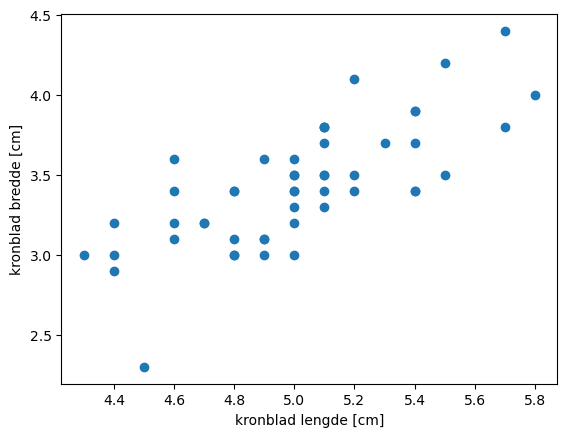

In [8]:
plt.scatter(df[df["species"] == "setosa"].sepal_length, df[df["species"] == "setosa"].sepal_width)
plt.xlabel("begerblad lengde [cm]");
plt.ylabel("begerblad bredde [cm]");

Ganske riktig! Det ser ut til å være en ganske klar sammenheng!

I prinsippet kan vi utføre multidimensjonal lineær regresjon. I dette tilfellet prøver vi derimot å predikere hva bredden til et kronblad vil være basert på en måling av lengden. Dette er det vi kaller enkel lineær regresjon hvor vi skal forutsi en respons (kronbladets bredde) basert på en enkelt predikator (kronbladets lengde). Vi antar altså at det er en lineær sammenheng mellom disse to verdiene som kan beskrives matematisk slik 

$Y \approx \beta_0 + \beta_1 X + \epsilon$

Hvor Y i dette tilfellet er kronbladets bredde, X er det vi måler, altså kronbladets lengde. De to konstantene får vi ved å gjøre en tilpasning til treningsdataene våre ved å bruke *minste kvadraters metode* dvs. å minimere *residual sum of squares* (RSS). Verdiene for $\beta_0$ og $\beta_1$ som minimerer RSS skriver vi ofte med en hatt, $\hat{\beta}_0$ og $\hat{\beta}_1$. På samme måte skriver vi $\hat{y}$ for å spesifisere at vi snakker om vår predksjon av Y. Vi kan da skrive

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x$,

hvor $x = X$

Siden funksjonen vi vil bruke for å tilpasse en enkel lineær regresjons til dataene våre kun inneholder én predikator så må vi legge til en ekstra dimensjon for at funksjonen ikke klager. I praksis vil det si å konvertere en vektor til en matrise med èn ekstra dimensjon. Man kan enkelt sjekke dimensjonen til et numpy-array object i pyhon ved å kalle på *shape*, den gir deg eksakt dimensjonene av arrayen. Før vi legger til en dimensjon: 

In [9]:
X_setosa_sepal_length.shape

(50,)

Vi legger til en ekstra dimensjon/akse:

In [10]:
X_setosa_sepal_length = X_setosa_sepal_length[:, np.newaxis]
X_setosa_sepal_width = X_setosa_sepal_width[:, np.newaxis]

... og vi får en ny dimensjon i arrayen vår. Dette vil bli mer intuitivt når vi skal se på tilfeller med flere predikatorer.

In [11]:
X_setosa_sepal_length.shape

(50, 1)

## Lineær Regresjon

scikit-learn har mange nyttige funksjoner for ulike typer maskinlæringsalgoritmer. De er i tillegg relativt godt dokumenterte - så her er det bare å slå seg løs. Vi skal nå bruke [*LinearRegression()*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Den tar enkelt og greit som input repsons og predikatoren i form av numpy-arrayer. Funksjonen *fit()* setter i gang prosessen med å finne den beste tilpasningen til dataene våre. 

In [12]:
clf = LinearRegression().fit(X_setosa_sepal_length,X_setosa_sepal_width)

Når den er ferdig kan vi hente ut veridene av $\hat{\beta}_0$ (intercept) og $\hat{\beta}_1$ (coef). Vi kan også få en første indikasjon på hvor bra tilpasningen er ved å skrive ut $R^2$.

In [13]:
print("Coefficient = %.2f"%clf.coef_)
print("Intercept = %.2f"%clf.intercept_)
print("Score/R^2 = %.2f"%clf.score(X_setosa_sepal_length,X_setosa_sepal_width))

Coefficient = 0.80
Intercept = -0.57
Score/R^2 = 0.55


Eller 

$\hat{y} = -0.57 + 0.8x$

Husk at score (eller $R^2$) er definert som

\begin{equation}
R^2 = 1 - \frac{RSS}{TSS}
\end{equation}

RSS (**r**esidual **s**um of **s**quares) er definert som

$$RSS = \sum_{i=1}^{n}\left(y_i - \hat{y}_{i}\right)^{2}$$

og TSS (**t**otal **s**um of **s**quares)

$$TSS = \sum_{i=1}^{n}\left(y_i - \bar{y}\right)^{2},$$

hvor $\bar{y}$ er det globale gjennomsnittet i dataene våre. 

$R^2$ er et mål på hvor mye av variasjon i Y som kan beskrives ved X. Dersom $R^2$ er nære 1 betyr det at en stor del av variasjonen i Y kan beskrives av regresjonsanalysen. Om den derimot er nære 0 betyr det at regresjonsanalysen i liten grad evner å beskrive variasjonen i responsen (Y). Det betyr

1. at den lineære modellen er feil
2. at variansen til feilen, $\epsilon$, $\sigma^2 = Var(\epsilon)$ er for høy

evt. begge deleer.

La oss uansett se hvordan den lineære modellen ser ut når vi plotter den sammen med datapunktene.

In [14]:
# Definer en x-vektor som dekker datapunktene (i dette tilfellet mellom 4 og 7 cm)
X_plot = np.linspace(4, 7, 300)
# Lag så responsfunksjonen ved å bruke parameterne fra modellen vår
fit = clf.intercept_[0] + clf.coef_[0]*X_plot

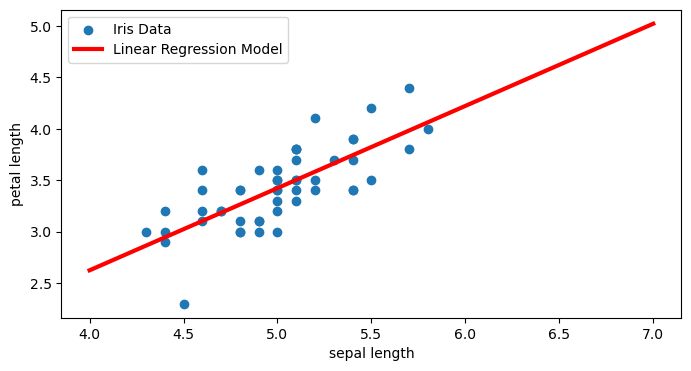

In [15]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.scatter(df[df["species"] == "setosa"].sepal_length, df[df["species"] == "setosa"].sepal_width,label="Iris Data")
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.legend()

## Alternativ framgangsmåte

Vi kan også bruke et annet bibliotek i python ([statsmodels](https://www.statsmodels.org/stable/index.html)) som er et godt alternativ til scikit-learn om vi enkelt vil hente ut enda mer informasjon om modellen vår. Da må vi starte med å importere denne 

In [16]:
import statsmodels.api as sm 

Vi kan bruke OLS (**o**rdinary **l**east **s**quare) på samme måte som vi brukte scikit-learn metoden over. Den gir oss da tilgang til enda mer informasjon om modellen. Merk at intercept/$\beta_0$ ikke er inkludert i standard-oppsettet i *statsmodels.ols()* og derfor eksplisitt må legges til ved å bruke *sm.add_constant()* på respons-vektoren.

In [17]:
X_setosa_sepal_length_const = sm.add_constant(X_setosa_sepal_length)

model = sm.OLS(X_setosa_sepal_width,X_setosa_sepal_length_const).fit() 
  
#display model summary 
print(model.summary()) 
  
# residual sum of squares 
print(model.ssr)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     58.99
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           6.71e-10
Time:                        09:53:01   Log-Likelihood:                -1.9002
No. Observations:                  50   AIC:                             7.800
Df Residuals:                      48   BIC:                             11.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5694      0.522     -1.091      0.2

In [18]:
# Definer en x-vektor som dekker datapunktene (i dette tilfellet mellom 4 og 7 cm)
X_plot = np.linspace(4, 7, 300)
# Lag så responsfunksjonen ved å bruke parameterne fra modellen vår
fit = model.params[0] + model.params[1]*X_plot

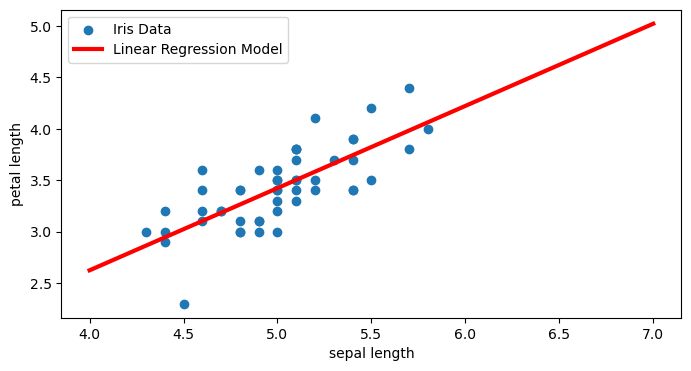

In [19]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.scatter(df[df["species"] == "setosa"].sepal_length, df[df["species"] == "setosa"].sepal_width,label="Iris Data")
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.legend()

In [20]:
xmean = np.mean(X_setosa_sepal_length.squeeze())

In [21]:
rse = np.sqrt(model.ssr/(48))
se_beta1 = (rse*rse)/(np.sum((X_setosa_sepal_length.squeeze()-xmean)*(X_setosa_sepal_length.squeeze()-xmean)))
print("Standard feil beta1 = %.6f"%se_beta1)

Standard feil beta1 = 0.010809


Oppgaven fra forelesning 15. januar stopper her. Vi har ikke gått gjennom hypotesetesting ennå. Koden under er derfor å anse som "work in progress".

# Hypotesetesting

In [22]:
tval = (model.params[1]-0)/se_beta1
print(tval)

73.8780703215139


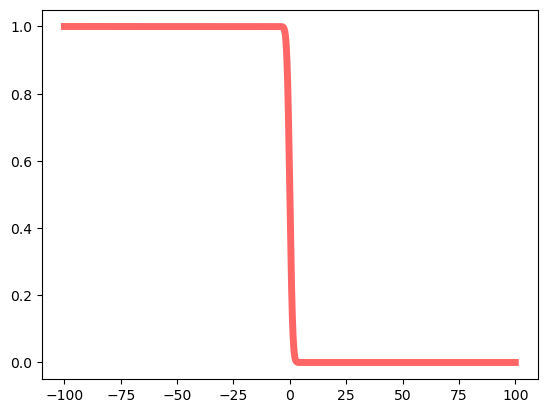

In [23]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

ndf = 50-2

x = np.arange(-100,100,0.001)#np.linspace(t.ppf(0.01, ndf),t.ppf(0.99, ndf), 100)
tsurv = t.sf(x, ndf)

ax.plot(x, tsurv,'r-', lw=5, alpha=0.6, label='t pdf')

In [ ]:
tsurv[cutval]

# Non dependent variables

In [ ]:
X_setosa_sepal_length = df[df["species"] == "setosa"].sepal_length.to_numpy()
X_versicolor_sepal_width = df[df["species"] == "versicolor"].sepal_width.to_numpy()

In [ ]:
plt.scatter(X_setosa_sepal_length, X_versicolor_sepal_width)

In [ ]:
X_setosa_sepal_length = X_setosa_sepal_length[:, np.newaxis]
X_versicolor_sepal_width = X_versicolor_sepal_width[:, np.newaxis]

In [ ]:
clf = LinearRegression().fit(X_setosa_sepal_length,X_versicolor_sepal_width)

In [ ]:
print("Coefficient = %.2f"%clf.coef_)
print("Intercept = %.2f"%clf.intercept_)
print("Score = %.2f"%clf.score(X_setosa_sepal_length,X_versicolor_sepal_width))

In [ ]:
X_plot = np.linspace(4, 7, 300)
fit = clf.intercept_[0] + clf.coef_[0]*X_plot
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X_setosa_sepal_length,X_versicolor_sepal_width)
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)

In [ ]:
X_versicolor_sepal_width = sm.add_constant(X_versicolor_sepal_width)
model = sm.OLS(X_setosa_sepal_length,X_versicolor_sepal_width).fit() 
  
#display model summary 
print(model.summary()) 
  
# residual sum of squares 
print(model.ssr)

In [ ]:
model.params

In [ ]:
X_plot = np.linspace(4, 7, 300)
fit = model.params[0] + model.params[1]*X_plot
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X_setosa_sepal_length,X_versicolor_sepal_width)
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)

In [ ]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

ndf = 50-2

x = np.linspace(-1,1,200)

ax.plot(x, t.sf(x, ndf),'r-', lw=5, alpha=0.6, label='t pdf')

In [ ]:
tfunc = t.sf(x, ndf)
prob = 0.0
n = -1
for i in x:
    n += 1
    if i > 0.540:
        print(n)
        break

In [ ]:
tfunc[154]

In [ ]:
c = abs(-0.540)
c

In [ ]:
tfunc

In [ ]:
c = np.arange(0,1,0.1)
csq = c

tail = t.sf(csq,ndf)

fig3, ax3 = plt.subplots(1,1)

ax3.bar(c, tail, color='blue')

ax3.grid(True,axis='y')
ax3.set_xlabel(r'$N$')
ax3.set_ylabel(r'$P(\chi_1^2>N^2$)')
ax3.set_title(r't-stat upper tail probability (p-value)')
ax3.set(xlim=(0, 1))
ax3.set_yscale('log')

yticks = 1/np.power(10,np.arange(1,-1,-1));
ax3.set_yticks(yticks)

plt.show()

In [ ]:
tail

In [ ]:
0.34546555*2